# ANN Model for Urban Sound Classification

## Installing Required Libraries

In [63]:
!pip install librosa

In [64]:
!pip install tensorflow

In [65]:
!pip install matplotlib

In [66]:
!pip install pandas

In [67]:
!pip install tqdm

In [68]:
!pip install imbalanced-learn

In [69]:
!pip install keras-tuner

## Importing Required Dependencies

In [122]:
# Standard Libraries
import os
from collections import Counter
import IPython.display as ipd

# Data Handling Libraries
import numpy as np
import pandas as pd
import joblib

# Audio Processing Libraries
import librosa
import librosa.display

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# Deep Learning Libraries (Tensorflow/Keras)
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation
from keras.utils import to_categorical
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

## Dataset Preparation

### Load the Dataset

In [123]:
metadata = pd.read_csv('../Data/UrbanSound8K.csv')
metadata

slice_file_name    fsID       start         end  salience  fold  \
0       100032-3-0-0.wav  100032    0.000000    0.317551         1     5   
1     100263-2-0-117.wav  100263   58.500000   62.500000         1     5   
2     100263-2-0-121.wav  100263   60.500000   64.500000         1     5   
3     100263-2-0-126.wav  100263   63.000000   67.000000         1     5   
4     100263-2-0-137.wav  100263   68.500000   72.500000         1     5   
...                  ...     ...         ...         ...       ...   ...   
8727     99812-1-2-0.wav   99812  159.522205  163.522205         2     7   
8728     99812-1-3-0.wav   99812  181.142431  183.284976         2     7   
8729     99812-1-4-0.wav   99812  242.691902  246.197885         2     7   
8730     99812-1-5-0.wav   99812  253.209850  255.741948         2     7   
8731     99812-1-6-0.wav   99812  332.289233  334.821332         2     7   

      classID             class  
0           3          dog_bark  
1           2  children_playing  
2           2  children_playing  
3           2  children_playing  
4           2  children_playing  
...       ...               ...  
8727        1          car_horn  
8728        1          car_horn  
8729        1          car_horn  
8730        1          car_horn  
8731        1          car_horn  

[8732 rows x 8 columns]

### Feature Extraction

In [124]:
# Here we process an audio file and extract its Mel-frequency cepstral coefficients (MFCCs).
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, sr=None)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}")
        return None
    return mfccs_scaled

In [125]:
# Set the path for the UrbanSound8K dataset
audio_dataset_path = r'F:\\SE\\SLIIT\\Y04S01\\Deep Learning\\Assignments\\DL\\Data'

In [126]:
# Define lists for features and labels
features = []
labels = []

In [13]:
# Iterate over each file and extract features
for index_num,row in tqdm(metadata.iterrows(), total=metadata.shape[0]):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=extract_features(file_name)
    features.append(data)
    labels.append(final_class_labels)

 33%|█████████████████████████▍                                                    | 2849/8732 [02:41<03:58, 24.71it/s]F:\SE\miniconda3\envs\audio_classification\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
100%|██████████████████████████████████████████████████████████████████████████████| 8732/8732 [07:34<00:00, 19.22it/s]


In [14]:
# Save extracted features in a DataFrame for future use
df_features = pd.DataFrame(features)
df_labels = pd.DataFrame(labels, columns=['label'])

df_extracted_features = pd.concat([df_features, df_labels], axis=1)

df_extracted_features.to_csv('./audio_features.csv', index=False)

###  Load and Prepare Data

In [127]:
df_audio_features = pd.read_csv('./audio_features.csv')
df_audio_features

0          1          2          3          4          5  \
0    -275.91843  119.49280 -98.211780 -66.515140 -42.606045   0.505065   
1    -500.90840  185.10641 -86.532820  49.858850   9.230822  22.548956   
2    -531.19530  186.93994 -70.349160  40.429245   9.121048  18.398588   
3    -476.78442  160.33328 -62.952843  50.751170  -0.174330  32.791600   
4    -521.24470  185.39265 -81.950470  46.473550  11.872088  23.491444   
...         ...        ...        ...        ...        ...        ...   
8727 -466.63190  193.29425 -63.960163  30.475616  -9.339019  23.975900   
8728 -396.77737  134.76804 -64.882770  42.310800  -1.868765   0.876937   
8729 -362.70322  165.08179 -60.780693  30.996470  -9.655406  23.180807   
8730 -404.62810  178.50473 -63.615627  25.944529 -10.428956  12.489921   
8731 -369.63705  147.90456 -63.150425  47.780520  -9.488717  33.391727   

              6          7         8          9  ...        31         32  \
0    -28.330938  -5.746867  9.992785   4.795412  ... -3.562049   1.710327   
1     -3.567175  12.220054  7.720082  -6.460392  ... -1.856354   0.372866   
2      6.283283  15.504061  9.613501  -7.113610  ... -0.291961   0.287639   
3    -17.469800  24.755478 -3.847784  -1.761176  ... -3.374202  -1.012279   
4      4.261836  13.637699  6.093238  -2.813453  ... -0.331206   2.441440   
...         ...        ...       ...        ...  ...       ...        ...   
8727 -14.627114  27.502554  3.764655   4.351699  ... -5.908267  -0.086640   
8728 -36.872646  42.781456 -9.984668  -5.920937  ...  1.580030  -4.441753   
8729 -18.668148  27.321250 -7.465636   7.173614  ...  2.579410  -2.790286   
8730 -24.788843  35.468410 -3.097389   0.915603  ... -0.693243  -2.208296   
8731 -30.122765  30.130272 -9.736057  14.229150  ... -3.804771 -11.533295   

            33        34        35        36        37        38        39  \
0     1.032513 -4.748238 -4.013623  0.116839  6.310030  1.492271  1.462320   
1    -3.269187 -1.969773 -1.598099  0.562077  0.463689 -0.359663  0.909601   
2    -3.358315  1.434627 -0.975246  2.386079 -0.347919 -3.844178 -0.731597   
3    -1.025993 -3.666372 -0.071535 -5.693183  1.876606 -1.428173  3.510686   
4     0.449653  1.609697 -2.679410 -0.054824 -2.050368 -1.784189  2.869685   
...        ...       ...       ...       ...       ...       ...       ...   
8727  8.064040  4.842944 -1.370681 -8.400169  1.039638  2.128600  4.718456   
8728  3.187478 -3.398616  1.737199  3.312875  2.611360  0.158990  0.844661   
8729  2.743992 -4.914998 -4.034190 -5.768603 -1.840645  2.607495  3.903050   
8730  4.955165 -0.435411 -1.857112 -7.561952 -0.168980  3.911847  4.805305   
8731  6.525465  1.719671  2.567312 -9.492548 -6.346464  1.464323  5.358858   

                 label  
0             dog_bark  
1     children_playing  
2     children_playing  
3     children_playing  
4     children_playing  
...                ...  
8727          car_horn  
8728          car_horn  
8729          car_horn  
8730          car_horn  
8731          car_horn  

[8732 rows x 41 columns]

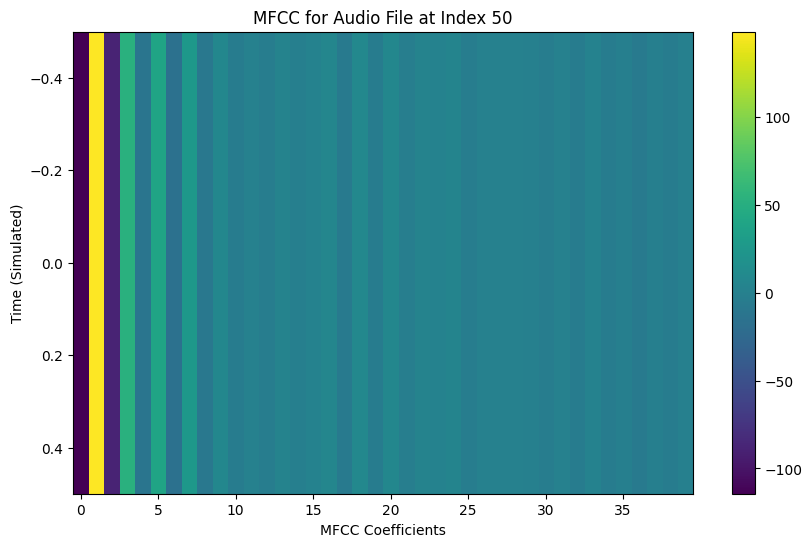

In [128]:
# Plot extracted MFCC feature of a random audio file 
def plot_extracted_mfcc(df, file_index):
    
    mfcc_features = df.iloc[file_index, :-1].values

    mfcc_features = mfcc_features.astype(float)

    mfcc_matrix = mfcc_features.reshape(1, -1) 

    plt.figure(figsize=(10, 6))
    plt.imshow(mfcc_matrix, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f'MFCC for Audio File at Index {file_index}')
    plt.xlabel('MFCC Coefficients')
    plt.ylabel('Time (Simulated)')
    plt.show()

plot_extracted_mfcc(df_audio_features, file_index=50)

In [129]:
# Prepare the data by separating the features (x) from the labels (y)
x = df_audio_features.drop(columns=['label'])
y = df_audio_features['label'].values

In [133]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype=object)

In [134]:
# Convert categorical variables into a binary column
y = np.array(pd.get_dummies(y, dtype=int))
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

### Data Resampling

In [135]:
# Use Synthetic Minority Over-sampling Technique (SMOTE ) to balance the class distribution in a dataset
smote = SMOTE(random_state=0)
x_resampled, y_resampled = smote.fit_resample(x, y)

y_resampled_labels = np.argmax(y_resampled, axis=1)

counter = Counter(y_resampled_labels)

print("Class distribution after resampling:\n", counter)

Class distribution after resampling:
 Counter({3: 1000, 2: 1000, 1: 1000, 0: 1000, 9: 1000, 6: 1000, 8: 1000, 5: 1000, 7: 1000, 4: 1000})


## Train-Test Split and Scaling

In [136]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=0)

In [137]:
# Standardize the features by removing the mean and scaling to unit variance
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

joblib.dump(scaler, 'standard_scaler.pkl')

['standard_scaler.pkl']

## Hyperparameter Tuning

### Function build_model

In [138]:
def build_model(hp):
    model = Sequential()
    
    model.add(Dense(
        units=hp.Int('units_1', min_value=128, max_value=512, step=64, default=256),
        input_shape=(40,)
    ))
    model.add(Activation(hp.Choice('activation_1', values=['relu', 'tanh'], default='relu')))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.7, step=0.1, default=0.5)))
    
    model.add(Dense(
        units=hp.Int('units_2', min_value=128, max_value=512, step=64, default=256)
    ))
    model.add(Activation(hp.Choice('activation_2', values=['relu', 'tanh'], default='relu')))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.7, step=0.1, default=0.5)))
    
    model.add(Dense(y_resampled.shape[1]))
    model.add(Activation('softmax'))
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### Function for Hyperparameter Tuning

In [139]:
# Early stopping function to prevent model from overfitiing while tuning
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [140]:
possible_epoch_values = [50, 100]

In [141]:
# Grid search
for epoch_count in possible_epoch_values:
    tuner = kt.GridSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory='tuner_dir',
        project_name=f'ANN_Audio_Classification_{epoch_count}'
    )

    history = tuner.search(x_train, y_train,
                 epochs=epoch_count,
                 validation_split=0.2,
                 callbacks=[early_stopping])

Reloading Tuner from tuner_dir\ANN_Audio_Classification_50\tuner0.json
Reloading Tuner from tuner_dir\ANN_Audio_Classification_100\tuner0.json


In [156]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
hyperparameters_df = pd.DataFrame(list(best_hp.values.items()), columns=["Hyperparameter", "Value"])
hyperparameters_df

Hyperparameter Value
0        units_1   256
1   activation_1  relu
2      dropout_1   0.5
3        units_2   256
4   activation_2  relu
5      dropout_2   0.2

In [ ]:

# Data for the two training runs
data = {
    "Epochs": [50, 100],
    "Units Layer 1": [288, 96],
    "Activation Layer 1": ["relu", "sigmoid"],
    "Dropout Layer 1": [0.2, 0.4],
    "Units Layer 2": [416, 320],
    "Activation Layer 2": ["tanh", "tanh"],
    "Dropout Layer 2": [0.1, 0.0],
    "Learning Rate": [0.0001, 0.0001],
    
}

# Creating a pandas DataFrame
df = pd.DataFrame(data)

df

## Model Building and Training

### Building the Model

In [143]:
model = Sequential()
model.add(Input(shape=(40,)))

model.add(Dense(units=best_hp.get('units_1')))
model.add(Activation(best_hp.get('activation_1')))
model.add(Dropout(best_hp.get('dropout_1')))

model.add(Dense(units=best_hp.get('units_2')))
model.add(Activation(best_hp.get('activation_2')))
model.add(Dropout(best_hp.get('dropout_2')))

model.add(Dense(y_resampled.shape[1]))
model.add(Activation('softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [153]:
# Model Summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 256)                 │          10,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │           2,570 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 236,576 (924.13 KB)

 Trainable params: 78,858 (308.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 157,718 (616.09 KB)

### Training the Model

In [144]:
# Train the model using the hyperparameters found in the GridSearch
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3520 - loss: 1.8541 - val_accuracy: 0.6600 - val_loss: 1.0630
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6141 - loss: 1.1491 - val_accuracy: 0.7269 - val_loss: 0.8529
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6957 - loss: 0.9431 - val_accuracy: 0.7575 - val_loss: 0.7425
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7225 - loss: 0.8338 - val_accuracy: 0.7881 - val_loss: 0.6597
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7584 - loss: 0.7322 - val_accuracy: 0.8006 - val_loss: 0.5892
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7804 - loss: 0.6674 - val_accuracy: 0.8106 - val_loss: 0.5602
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7933 - loss: 0.6204 - val_accuracy: 0.8281 - val_loss: 0.5259
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8110 - loss: 0.5770 - val_accu

In [145]:
model.save('../Models/ann_audio_model.keras')

In [146]:
history_dictionary = history.history
joblib.dump(history_dictionary, '../Models/ann_model_history.pkl')

['../Models/ann_model_history.pkl']

## Model Evaluation

### Model Loss and Accuracy

In [147]:
load_model = load_model('../Models/ann_audio_model.keras')

In [148]:
test_metrics = load_model.evaluate(x_test, y_test, verbose=0)

print(f"Loss: {test_metrics[0]}")
print(f"Test Accuracy: {test_metrics[1]}")

Loss: 0.2500264048576355
Test Accuracy: 0.9284999966621399


### Plotting

#### Training History

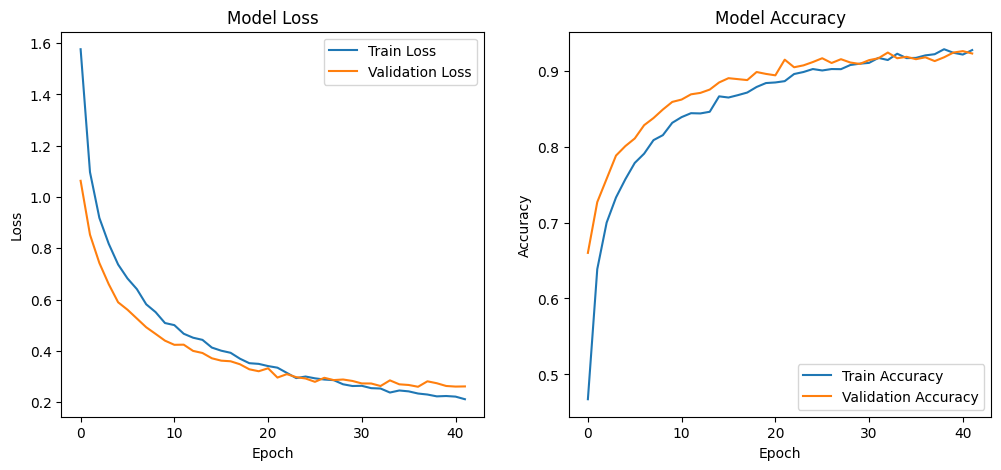

In [149]:
def plot_training_history(history_dictionary):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_dictionary['loss'], label='Train Loss')
    plt.plot(history_dictionary['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history_dictionary['accuracy'], label='Train Accuracy')
    plt.plot(history_dictionary['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.show()

plot_training_history(history_dictionary)

#### Classification Report

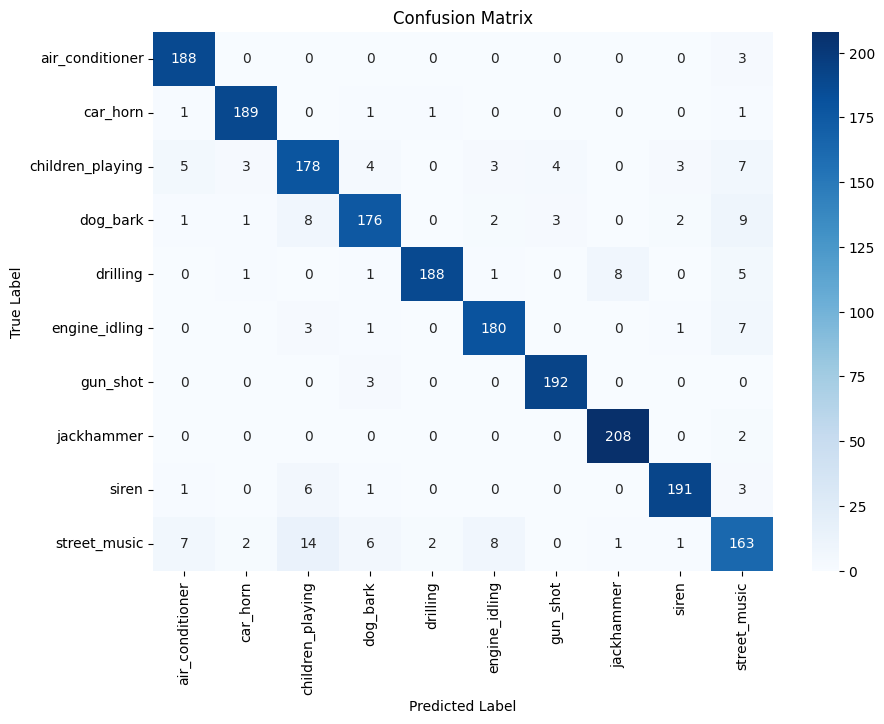

Classification Report:

                  precision    recall  f1-score   support

 air_conditioner       0.93      0.98      0.95       191
        car_horn       0.96      0.98      0.97       193
children_playing       0.85      0.86      0.86       207
        dog_bark       0.91      0.87      0.89       202
        drilling       0.98      0.92      0.95       204
   engine_idling       0.93      0.94      0.93       192
        gun_shot       0.96      0.98      0.97       195
      jackhammer       0.96      0.99      0.97       210
           siren       0.96      0.95      0.95       202
    street_music       0.81      0.80      0.81       204

        accuracy                           0.93      2000
       macro avg       0.93      0.93      0.93      2000
    weighted avg       0.93      0.93      0.93      2000

Accuracy: 0.9265
Precision (Weighted): 0.9265
Recall (Weighted): 0.9265
F1 Score (Weighted): 0.9262


In [150]:
def print_classification_metrics(y_true, y_pred, label_encoder):
    
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    
    # Display Confusion Matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Classification Report
    report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_)
    print("Classification Report:\n")
    print(report)

    # Additional Metrics
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")

print_classification_metrics(y_test, y_pred, label_encoder)


## Test on Unseen Data

In [151]:
def test_on_unseen_data(model, audio_files, scaler, label_encoder):
    features = []

    for file_name in audio_files:
        data = extract_features(file_name)
        if data is not None:
            features.append(data)

    features = np.array(features)

    features = features.reshape(features.shape[0], -1)

    features = scaler.transform(features)

    predictions = model.predict(features)

    predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

    return predicted_labels

In [152]:
# Load useen data to get predictions
unseen_audio_files = [r'F:\SE\SLIIT\Y04S01\Deep Learning\Assignments\DL\Data\sm.wav']
predicted_classes = test_on_unseen_data(load_model, unseen_audio_files, scaler, label_encoder)

print("Predicted classes for unseen audio files:", predicted_classes)

for audio_file in unseen_audio_files:
    audio_data, sample_rate = librosa.load(audio_file, sr=None)
    print(f"Playing audio file: {audio_file}")
    ipd.display(ipd.Audio(audio_data, rate=sample_rate))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


F:\SE\miniconda3\envs\audio_classification\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted classes for unseen audio files: ['street_music']
Playing audio file: F:\SE\SLIIT\Y04S01\Deep Learning\Assignments\DL\Data\sm.wav
